In [13]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os
import torch as pt
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.mokito.modules import *
from scipy.spatial.distance import pdist

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())


Created variables:
out_trajectories = output/trajectories/
out_isokann = output/isokann/
out_mokito = output/mokito/


In [2]:
# Load initial and final states 
X0 = np.load(out_trajectories + 'X0.npy')    #  X0.shape = (N, 2) 
Xt = np.load(out_trajectories + 'Xt.npy')    #  Xt.shape = (N, M, 2)

# Load chi function
chi0 = np.load(out_isokann + 'chi0.npy')     #  chi0.shape = (Npoints,)

data           =  OrganizeData(X0, Xt, chi0)

FIs    =  FindIntervals(data, Nintervals=3, clustering = 'grid')



Check shape of input data
X0.shape   =  (2000, 2)
Xt.shape   =  (2000, 10, 2)
chi0.shape =  (2000,)
  


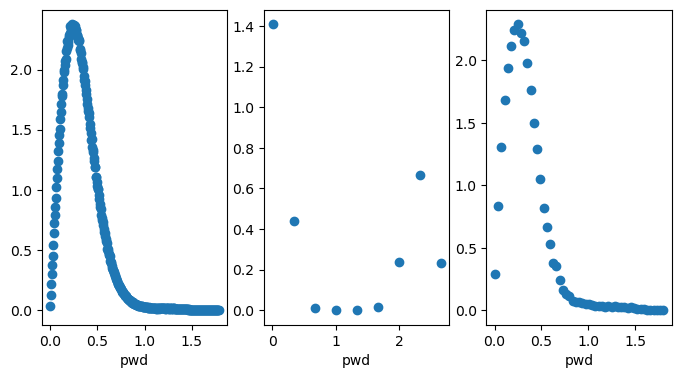

In [3]:
fig, ax = plt.subplots(1, FIs.Nintervals, figsize=(16*in2cm, 8*in2cm))  

for i in range(FIs.Nintervals):

    Xi = data.X0[FIs.chi_intervals == i]

    pwd = pdist(Xi, metric='euclidean')
    density, bin_edges = np.histogram(pwd, bins=int(len(Xi)/5), density=True)

    ax[i].plot(bin_edges[0:-1], density, 'o')
    ax[i].set_xlabel('pwd')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)


In [4]:
FNs    =  FindNodes(data, FIs, eps = [1, 1, 1, 1, 1], 
                                 theta  = [2,2,2, 2, 2], 
                                 algorithm = 'CNNC', 
                                 metric = 'L2norm') 
print(np.sum(FNs.nodes==-1))

print("Number of nodes:", str(FNs.Nnodes))
print("Size of nodes:", str(FNs.nodes_size))
print(np.sum(FNs.nodes==-1))


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

0
Number of nodes: 4
Size of nodes: [1687   36   12  265]
0


In [10]:
BAM    =  BuildAdjacencyMatrix(data, FNs, size_mlp=10, threshold =10, algorithm='mlp')


BG     =  BuildGraph(FNs, BAM)
CE     =  CalculateEnergy(FNs)

G      =  BG.G

/scratch/htc/ldonati/anaconda32/envs/emma32/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 2000/2000 [00:01<00:00, 1146.50it/s]


Text(0.5, 1.0, '(b) Energy')

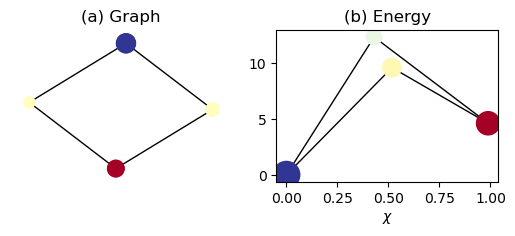

In [11]:
#posG = nx.kamada_kawai_layout(Gd)  # kamada_kawai_layout
#Make graph and nice plots
posG = nx.spring_layout(G, center=[0,0], seed = 20)  # kamada_kawai_layout

index_chi_node = FNs.index_chi_node
nodes_size     = np.log(FNs.nodes_size)*50

energy         = CE.energy
P              = BAM.P

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16*in2cm, 5*in2cm), facecolor='white')

nx.draw(G, 
        posG, 
        with_labels=False, 
        node_color=index_chi_node, 
        cmap = cm.RdYlBu_r, 
        node_size= nodes_size*0.5,
        edge_color='k', 
        width=1,
        ax=ax1
       )


nx.draw_networkx_nodes(G, 
                       posG, 
                       node_size=nodes_size*0.5,
                       node_color=index_chi_node, 
                       cmap = cm.RdYlBu_r, 
                       ax=ax1)

ax1.set_title('(a) Graph')

################## PLOT ENERGY
chi_nodes = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False)


for i in range(G.number_of_nodes()):
    for j in range(i+1,G.number_of_nodes()):
        if BAM.P[i,j]>0:
            ax2.plot([chi_nodes[i], chi_nodes[j]], [energy[i], energy[j]], 'k-', linewidth = 1,zorder=-1) 



ax2.scatter(chi_nodes, energy, s = nodes_size, c = chi_nodes, cmap = cm.RdYlBu_r)

ax2.set_xlabel(r'$\chi$')
ax2.set_title('(b) Energy')

In [14]:
nx.write_gml(G, out_mokito + "MKM.gml")

with open(out_mokito + "energy_MKM.npy", 'wb') as f:
    np.save(f, chi_nodes)
    np.save(f, energy)
    np.save(f, nodes_size)

In [ ]:
# The following code converts the networkx graph into a mapper graph
from collections import defaultdict
import networkx as nx
import kmapper as km
from kmapper import jupyter # Creates custom CSS full-size Jupyter screen
from kmapper.plotlyviz import mpl_to_plotly



all_chi    =  chi0

mapper = km.KeplerMapper()

graph = {
    "nodes": {},
    "links": [],
    'meta_data': {'projection': 'custom',
    'n_cubes': FNs.nodes,
    'perc_overlap': 0,
    'clusterer': 'DBSCAN(min_samples=3)',
    'scaler': 'None'},
    'meta_nodes': defaultdict(list, {})
}


# States
nodes_dict = defaultdict(list)
names_nodes = {}
states_nodemembership_x0 = FNs.nodes

for i in range(FNs.Nnodes):
    key = "cube" + str(int(i)) + "_cluster0" 
    names_nodes[i] = key

for i, node in enumerate(states_nodemembership_x0):
    key = "cube" + str(int(node)) + "_cluster0" 
    nodes_dict[key].append(i)

graph["nodes"] = nodes_dict


# Edges

a = dir(FNs)    
d_links = defaultdict(list)

adjacency_matrix = BAM.Ad

np.set_printoptions(suppress=True)

for i in range(FNs.Nnodes):
    
    key_i =  "cube" + str(i) + "_cluster0" 
    
    for j in range(i + 1):
        
        key_j = "cube" + str(j) + "_cluster0" 
        
        if adjacency_matrix[i, j] > 0:
            
            d_links[key_i].append(key_j)

graph["links"] = d_links



plotly_RdYlBu = mpl_to_plotly(cm.RdYlBu_r, 20)



                

mapper.visualize(graph, 
                    path_html           = out_mokito + "MKM.html",
                    color_values        = all_chi,
                    color_function_name = "labels",
                    colorscale          = plotly_RdYlBu,
                    title               = "Molecular Kinetics Map")

#jupyter.display(path_html = out_mokito + "MKM.html")
